# Popular Data Science Questions

In this project, I would be investigating the [Data Science Stack Exchange](https://datascience.stackexchange.com/) site to determine what kind of data science questions are learners most interested in. The Data Science Stack Exchange (DSSE) is a data science dedicated site and coupled with the fact that there are a lot of unanswered questions makes it an ideal candidate for the investigation. On the DSSE website, technical kinds of questions are the usual and are welcomed on the site. Technical questions range from the the concepts behind key data science topics and also in relation to code handling. Besides questions, the site's home also links to the users of the site as well as job listings. Within each question post, related questions related to the questions being asked are shown on the side. There are also tags associated with the question which could help identify what the question is relating to. These tags are very useful in categorizing content data science learners are asking on the site.

# Stack Exchange Data Explorer (SEDE)

Stack Exchange provides a public data base for each of its website, including the Data Science Stack Exchange site. Queries could be entered onto this [public data base](https://data.stackexchange.com/datascience/query/new) for exploration. Upon further investigation of the various tables from Data Science Stack Exchange's data model, several tables are of interest which could be useful and promising towards finding the most popular content. These tables include:
* `Tags`
* `Posts`
* `PostTags` which links the `PostId` of `Id` from `Posts` to the `TagId` of `Id` from `Tags` (ile the table connecting the `Tags` and `Posts` table to associate the tags for each post)

Looking at the `Posts` table, there are a lot of columns but only the relevant columns that useful towards our goal should be used for the analysis. The relevant columns are as follows, along with accompanying description of what each column is about:

* `Id`: An identification number for the post.
* `PostTypeId`: An identification number for the type of post.

<img src="https://dq-content.s3.amazonaws.com/469/PostTypes.png"/>

* `Score`: The post's score.
* `ViewCount`: How many times the post was viewed.
* `Tags`: What tags were used.
* `AnswerCount`: How many answers the question got (only applicable to question posts).
* `FavoriteCount`: How many times the question was favored (only applicable to question posts).

With the exception of the `Tags` column, the last few columns related to how popular the post was which is the kind of information that is relevant for our investigation.

Querying the data base, an overwhelming majority of posts are either questions or answers; the other post types are inconsequential and so, they can be ignored. A query is ran against the SEDE DSSE database to extract all the columns listed above for all the questions in 2019:

`SELECT Id, PostTypeId, CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount
FROM Posts
WHERE YEAR(CreationDate) = 2019 AND PostTypeId = 1;`

The result of the query is stored in a csv file `2019_questions.csv` to be loaded in as a pandas DataFrame.


# Data Exploration and Cleaning

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Reading in the csv file into a pandas DataFrame

df = pd.read_csv("2019_questions.csv", parse_dates=['CreationDate'])

In [3]:
# First five rows of the dataframe
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [4]:
# Overview of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


Initial data exploration would show that there are substantial missing (null) values in the `FavoriteCount` column. The datatypes of the columns are adequate and in the right form. However, for the `Tags` column, there are several values for each row encased in arrow brackets ('<' and '>'). These values could be split out such that each row would only have one tag.

In [5]:
# Filling in the missing values with 0
df.fillna(0, inplace=True)
df['FavoriteCount'] = df['FavoriteCount'].astype(int)
df.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

In [6]:
# Cleaning the `Tags` column to convert to a list of values
df['Tags'] = df['Tags'].str.replace('><',',').str.replace(r'[<>]','').str.split(',')

In [7]:
df.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,"[machine-learning, data-mining]",0,0
1,44420,2019-01-23 09:34:01,0,25,"[machine-learning, regression, linear-regressi...",0,0
2,44423,2019-01-23 09:58:41,2,1651,"[python, time-series, forecast, forecasting]",0,0
3,44427,2019-01-23 10:57:09,0,55,"[machine-learning, scikit-learn, pca]",1,0
4,44428,2019-01-23 11:02:15,0,19,"[dataset, bigdata, data, speech-to-text]",0,0


# Most Used and Most Viewed Tags

To determine the most popular tags, we will be considering the number of times a tag was used as well as how many times a question with that tag was viewed.

## How many times each tag was used

In [8]:
# Initializing an empty dictionary to store the counts of tags being used
tag_counts = {}

# Looping through the `Tags` column
for tags in df['Tags']:
    # Looping through each tag in the list
    for tag in tags:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1

# Loading the dictionary into a DataFrame for better viewing
tag_counts_df = pd.DataFrame.from_dict(tag_counts,orient='index')
tag_counts_df.rename(columns={0:'Count'}, inplace=True)

# Looking at just the top 20 counts, sorted in descending count order
top_20_counts = tag_counts_df.sort_values('Count', ascending=False).head(20)
top_20_counts

,Count
machine-learning,2693
python,1814
deep-learning,1220
neural-network,1055
keras,935
classification,685
tensorflow,584
scikit-learn,540
nlp,493
cnn,489


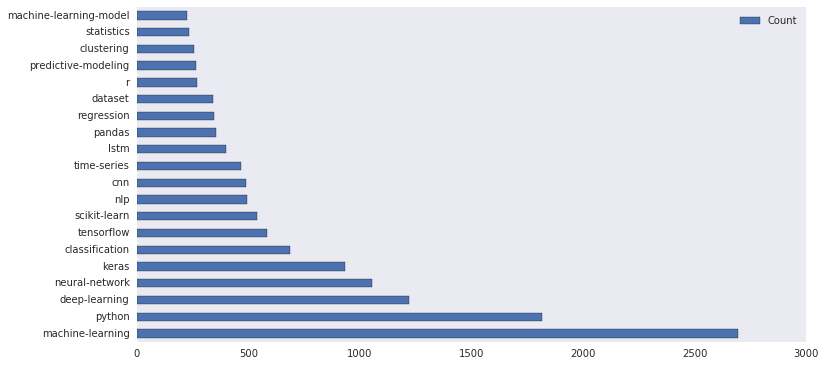

In [9]:
# Creating a horizontal bar chart for visualization
top_20_counts.plot(kind='barh', figsize=(12,6), grid=False)

## How many times each tag was viewed

In [10]:
# Initializing an empty dictionary to store the tag views
tag_views = {}

# Looping through the DataFrame by iterating over the rows
for index, row in df.iterrows():
    for tag in row['Tags']:
        if tag in tag_views:
            tag_views[tag] += row['ViewCount']
        else:
            tag_views[tag] = row['ViewCount']

# Loading the dictionary into a DataFrame for better viewing
tag_views_df = pd.DataFrame.from_dict(tag_views,orient='index')
tag_views_df.rename(columns={0:'Views'}, inplace=True)

# Looking at just the top 20 counts, sorted in descending count order
top_20_views = tag_views_df.sort_values('Views', ascending=False).head(20)
top_20_views


,Views
python,537585
machine-learning,388499
keras,268608
deep-learning,233628
pandas,201787
neural-network,185367
scikit-learn,128110
tensorflow,121369
classification,104457
dataframe,89352


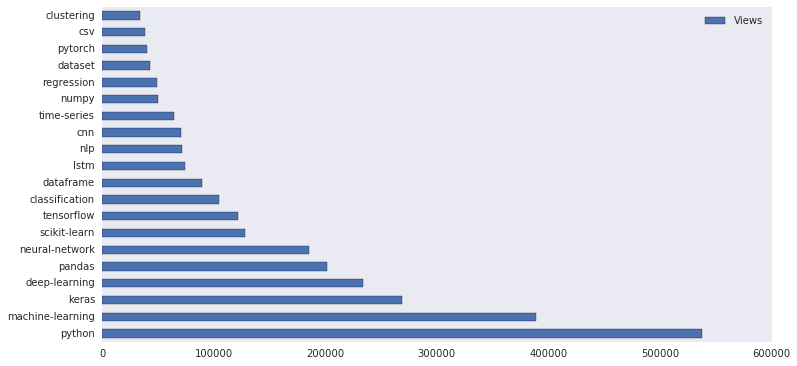

In [11]:
# Creating a horizontal bar chart for visualization
top_20_views.plot(kind='barh', figsize=(12,6), grid=False)

# Domain Knowledge

From above, it is clear that the most used tags are also the most viewed tags. Looking at possible relations between the tags, almost all of tags relate to machine learning. Several tags like `pytorch`, `cnn`, `nlp`, `tensorflow` and `keras` all relate to deep learning, which is a subset of machine learning. As such, it is clear that the most popular topic right now is deep learning, of which most data science learners would have lots of questions on.

# Is Deep Learning Just a Fad?

In order to officially make a recommendation as to deep learning being the most popular, it would be nice to solidify the findings with additional proof to show learn that deep learning is not just a fad. It is worthwhile to investigate if interest in deep learning is slowing down or continuing to grow. To track the interest in deep learning across time, we would:
* Count how many deep learning questions are asked per time period
* The total amount of questions per time period
* How many deep learning questions there are relative to the total amount of questions per time period

In [12]:
# Reading in the all_questions.csv into a DataFrame
all_questions = pd.read_csv("all_questions.csv", parse_dates=['CreationDate'])

# Transforming the tags column in similar fashion as per before
all_questions['Tags'] = all_questions['Tags'].str.replace('><',',').str.replace(r'[<>]','').str.split(',')

In [13]:
all_questions.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


In [14]:
# Creating a `CreationMonth` column to track the month in which the post was created
all_questions['CreationMonth'] = all_questions['CreationDate'].dt.year * 100 + all_questions['CreationDate'].dt.month

In [15]:
# Creating a custom function to deal with classifying whether a post relates to Deep Learning or not
def classify(tags):
    result = False
    for tag in tags:
        if tag.lower() in ['pytorch', 'cnn', 'rnn', 'nlp', 'lstm', 'tensorflow', 'keras', 'neural-network', 'deep-learning']:
            result = True
    return result
    

# Creating a 'Deep_Learning' column which is Boolean to classify whether a post is a Deep Learning question or not
all_questions['Deep_Learning'] = all_questions['Tags'].apply(classify)

In [16]:
# Counting how many deep learning questions are asked per time period
deep_learning_count = all_questions.groupby('CreationMonth')['Deep_Learning'].sum().astype(int)
deep_learning_count

CreationMonth
201405      4
201406     12
201407     12
201408      6
201409      4
201410     11
201411      8
201412     10
201501      5
201502      6
201503      8
201504      6
201505     17
201506     16
201507     20
201508     12
201509     12
201510     17
201511     14
201512     33
201601     41
201602     26
201603     46
201604     33
201605     43
201606     33
201607     51
201608     61
201609     33
201610     46
         ... 
201708    102
201709     59
201710     80
201711    130
201712    140
201801    175
201802    155
201803    180
201804    163
201805    234
201806    163
201807    202
201808    258
201809    221
201810    169
201811    165
201812    158
201901    213
201902    298
201903    281
201904    308
201905    305
201906    333
201907    378
201908    291
201909    251
201910    248
201911    276
201912    298
202001    176
Name: Deep_Learning, Length: 69, dtype: int64

In [17]:
# Counting how many questions are asked per time period
all_questions_count = all_questions.groupby('CreationMonth').size()
all_questions_count

CreationMonth
201405     58
201406     99
201407     76
201408     65
201409     48
201410     71
201411     64
201412     81
201501     63
201502     73
201503     54
201504     71
201505     92
201506    121
201507    117
201508    101
201509     93
201510    115
201511    117
201512    150
201601    172
201602    148
201603    196
201604    181
201605    164
201606    173
201607    208
201608    224
201609    153
201610    167
         ... 
201708    294
201709    195
201710    236
201711    340
201712    322
201801    416
201802    385
201803    420
201804    446
201805    587
201806    415
201807    465
201808    540
201809    507
201810    461
201811    412
201812    421
201901    552
201902    712
201903    723
201904    746
201905    829
201906    818
201907    909
201908    766
201909    719
201910    645
201911    667
201912    724
202001    459
Length: 69, dtype: int64

In [18]:
# Putting both series into a DataFrame and calculating the ratio of deep learning questions to total per month
final_table = pd.DataFrame(deep_learning_count)
final_table['Total_Count'] = all_questions_count
final_table['Ratio'] = round(final_table['Deep_Learning'] / final_table['Total_Count'],4)

In [19]:
import datetime as dt

# Format the index
final_table.reset_index(inplace=True)
final_table['CreationMonth'] = final_table['CreationMonth'].astype(str).apply(lambda x: dt.datetime.strptime(x, "%Y%m"))
final_table.set_index('CreationMonth', inplace=True)

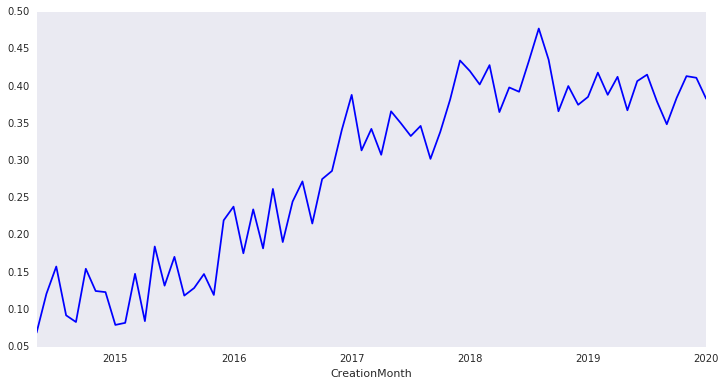

In [20]:
# Plotting a bar chart to track the time series of the ratios
ax = final_table['Ratio'].plot(kind='line', grid=False, figsize=(12,6), color='blue')

# Conclusion

It seems that deep learning questions was a high-growth trend since the start of DSSE and it looks like it is plateauing. There is no evidence to suggest that interest in deep learning is decreasing and so we maintain our previous idea of proposing that we create deep learning content.